In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')
    
print(device)
device =  torch.device('cpu')

cpu


In [3]:
print(device)

cpu


In [4]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [5]:
data_df = pd.read_csv("all_data_lake_modeling_in_time.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,diffusivity,temp_heat01,temp_diff02,day_of_year,time_of_day,temp_mix03,temp_conv04,temp_initial00,obs_temp,input_obs
0,1,13.965021,717.887954,-32.080993,-6.880394,0.0,0.8,1.803546,0.008386,36000000.0,...,0.000037,15.416676,15.416676,155,1,15.426904,15.426904,15.489510,22.279,22.279
1,2,13.965021,717.887954,-32.080993,-6.880394,0.0,0.8,1.803546,0.008386,36000000.0,...,0.000031,15.448083,15.437735,155,1,15.401481,15.401481,15.448078,22.295,22.295
2,3,13.965021,717.887954,-32.080993,-6.880394,0.0,0.8,1.803546,0.008386,36000000.0,...,0.000028,15.376622,15.374550,155,1,15.346109,15.346109,15.376617,22.091,22.091
3,4,13.965021,717.887954,-32.080993,-6.880394,0.0,0.8,1.803546,0.008386,36000000.0,...,0.000028,15.287991,15.287547,155,1,15.272596,15.272596,15.287987,22.296,22.296
4,5,13.965021,717.887954,-32.080993,-6.880394,0.0,0.8,1.803546,0.008386,36000000.0,...,0.000029,15.195124,15.195829,155,1,15.193004,15.193004,15.195121,22.231,22.231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495570,21,17.945001,796.182785,-59.448422,-13.843945,0.0,0.8,0.322170,0.000534,36000000.0,...,0.000015,8.373718,8.375543,213,23,8.375543,8.375543,8.373683,11.099,11.099
495571,22,17.945001,796.182785,-59.448422,-13.843945,0.0,0.8,0.322170,0.000534,36000000.0,...,0.000017,7.324853,7.326184,213,23,7.326184,7.326184,7.324806,11.099,11.099
495572,23,17.945001,796.182785,-59.448422,-13.843945,0.0,0.8,0.322170,0.000534,36000000.0,...,0.000020,6.297841,6.298671,213,23,6.298671,6.298671,6.297760,11.099,11.099
495573,24,17.945001,796.182785,-59.448422,-13.843945,0.0,0.8,0.322170,0.000534,36000000.0,...,0.000029,5.282023,5.282477,213,23,5.282477,5.282477,5.282023,11.099,11.099


In [6]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 19823
Number of training points: 297325


# Normalizing Data

In [7]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [8]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity' ,'temp_heat01']
output_columns = ['temp_diff02']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [9]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (297325, 15), X_test: (198250, 15)
y_train: (297325, 1), y_test: (198250, 1)


In [10]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [11]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [12]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [13]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500


optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [14]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=15, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [15]:
# mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
# std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)

# mean_temp = torch.tensor(input_mean[input_column_ix[14]]).to(device)
# std_temp = torch.tensor(input_std[input_column_ix[14]]).to(device)

# mean_out = torch.tensor(output_mean).to(device)
# std_out = torch.tensor(output_std).to(device)
    
# def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
#     # de-normalise data
#     diff = diff * std_diff + mean_diff

#     # INPUT DATA FROM PREVIOUS MODULE
#     t = temp * std_temp + mean_temp # temperature profile from previous module output

#     # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     j = len(t)
#     y = torch.zeros((len(t), len(t)), dtype=torch.float64).to(device)

#     alpha = (dt/dx**2) * diff

#     az = - alpha # subdiagonal
#     bz = 2 * (1 + alpha) # diagonal
#     cz = - alpha # superdiagonal

#     bz[0] = 1
#     az[len(az)-2] = 0
#     bz[len(bz)-1] = 1
#     cz[0] = 0

#     az = az[1:,:]
#     cz = cz[:-1,:]

#     y = torch.diag(bz[:, 0])+torch.diag(az[:, 0],-1)+torch.diag(cz[:, 0],1) #slightly efficient way of computing the diagonal matrices
#     y[j-1, j-1] = 1
    
#     mn = torch.zeros_like(t)  
#     mn[0] = t[0]
#     mn[len(mn)-1] = t[len(t)-1]
    
#     mn[1:j-1] = alpha[1:j-1,0]*t[:j-2] + 2 * (1 - alpha[1:j-1,0])*t[1:j-1] + alpha[1:j-1,0]*t[1:j-1] #is be same as the loop
    
#     # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
#     proj = torch.linalg.solve(y, mn)

#     mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
#     proj = (proj-mean_out)/std_out

#     proj = proj.to(torch.double)
#     return proj

In [16]:
print(input_column_ix)
print(input_column_ix[13])
print(input_column_ix[5])
print(input_column_ix[:2])
print(input_column_ix[11])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13, 14]
13
5
[0, 1]
16


In [17]:
mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [18]:
# diffusivity_true = torch.tensor(X_train[:,input_column_ix[13]], device=device).unsqueeze(1)
# temp_heat_true = torch.tensor(X_train[:,input_column_ix[14]], device=device)#.unsqueeze(1)
# mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
# std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)
# print(mean_diff, std_diff)

# pred = implicit_diffusion(diff=diffusivity_true, 
#                           temp=temp_heat_true)

# print(torch.mean((pred-y_train)**2))

In [19]:
# time = 20
# # print(pred[25*time:25*(time+1)])
# # print(y_train[25*time:25*(time+1)])
# print((pred[25*time:25*(time+1)]-y_train[25*time:25*(time+1)]).abs())

In [20]:
# # test if the Crank-Nicholson scheme works

# temp = torch.rand(5,1).to(device)
# diff = torch.rand(5,1).to(device)
# print(temp), print(diff)
# implicit_diffusion(diff, temp, input_mean, input_std,
#                                  output_mean, output_std)

In [21]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        
        # get temperature input
        temp_input = x[:,14]
        
        optimizer.zero_grad()
        proj = model(x)
        
        pred = implicit_diffusion(proj, temp_input)
#         pred = pred.to(dtype=torch.float32)
        
#         print(pred.mean(), y.mean(), pred.std(), y.std())
        loss = criterion(pred, y)
        
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            temp_input = x[:,14] #* std + mean

            optimizer.zero_grad()
            proj = model(x)

            pred = implicit_diffusion(proj, temp_input)

            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 1/1000 [00:13<3:50:34, 13.85s/it]

Epoch : 0, Train_loss: 0.0012895059671974506, Test_loss: 3.5430852840043592e-06


  5%|▌         | 51/1000 [14:59<5:41:19, 21.58s/it]

Epoch : 50, Train_loss: 2.4325588217211984e-06, Test_loss: 2.8273812940664467e-06


 10%|█         | 101/1000 [29:57<5:03:08, 20.23s/it]

Epoch : 100, Train_loss: 2.3425206907955455e-06, Test_loss: 2.8112684365614722e-06


 15%|█▌        | 151/1000 [45:12<4:38:46, 19.70s/it]

Epoch : 150, Train_loss: 2.324926243399137e-06, Test_loss: 2.82932438093708e-06


 20%|██        | 201/1000 [1:00:13<4:37:26, 20.83s/it]

Epoch : 200, Train_loss: 2.2809370050055696e-06, Test_loss: 2.8578008825672952e-06


 25%|██▌       | 251/1000 [1:15:19<4:04:56, 19.62s/it]

Epoch : 250, Train_loss: 2.2634554352865375e-06, Test_loss: 2.8368258332517857e-06


 30%|███       | 301/1000 [1:30:29<4:01:56, 20.77s/it]

Epoch : 300, Train_loss: 2.26502240538682e-06, Test_loss: 2.8270985209092396e-06


 35%|███▌      | 351/1000 [1:45:51<3:39:31, 20.29s/it]

Epoch : 350, Train_loss: 2.228868184972924e-06, Test_loss: 2.8546815288316236e-06


 40%|████      | 401/1000 [2:01:04<3:19:45, 20.01s/it]

Epoch : 400, Train_loss: 2.248168565172257e-06, Test_loss: 2.8538185903181244e-06


 45%|████▌     | 451/1000 [2:16:24<3:09:20, 20.69s/it]

Epoch : 450, Train_loss: 2.2263760367282555e-06, Test_loss: 2.8601937819802513e-06


 50%|█████     | 501/1000 [2:31:30<2:48:52, 20.31s/it]

Epoch : 500, Train_loss: 2.190284560385298e-06, Test_loss: 2.8446904513141055e-06


 55%|█████▌    | 551/1000 [2:46:30<2:28:00, 19.78s/it]

Epoch : 550, Train_loss: 2.1936718253802623e-06, Test_loss: 2.85204131741418e-06


 60%|██████    | 601/1000 [3:01:40<2:08:23, 19.31s/it]

Epoch : 600, Train_loss: 2.1709837319241045e-06, Test_loss: 2.8512353925641527e-06


 65%|██████▌   | 651/1000 [3:16:57<1:59:45, 20.59s/it]

Epoch : 650, Train_loss: 2.1743455211484336e-06, Test_loss: 2.8444439768216983e-06


 70%|███████   | 701/1000 [3:32:01<1:40:52, 20.24s/it]

Epoch : 700, Train_loss: 2.1640406795092267e-06, Test_loss: 2.8505790750222417e-06


 75%|███████▌  | 751/1000 [3:46:41<1:27:16, 21.03s/it]

Epoch : 750, Train_loss: 2.1799094804998504e-06, Test_loss: 2.8509634070881353e-06


 80%|████████  | 801/1000 [3:59:21<19:19,  5.83s/it]  

Epoch : 800, Train_loss: 2.1886991253298728e-06, Test_loss: 2.849522146201954e-06


 85%|████████▌ | 851/1000 [4:01:40<07:46,  3.13s/it]

Epoch : 850, Train_loss: 2.1727775805135368e-06, Test_loss: 2.8502948245074353e-06


 90%|█████████ | 901/1000 [4:03:55<05:05,  3.08s/it]

Epoch : 900, Train_loss: 2.1685975554536704e-06, Test_loss: 2.8479893082828254e-06


 95%|█████████▌| 951/1000 [4:06:09<02:28,  3.03s/it]

Epoch : 950, Train_loss: 2.203638974383497e-06, Test_loss: 2.854312461080389e-06


100%|██████████| 1000/1000 [4:08:19<00:00, 14.90s/it]


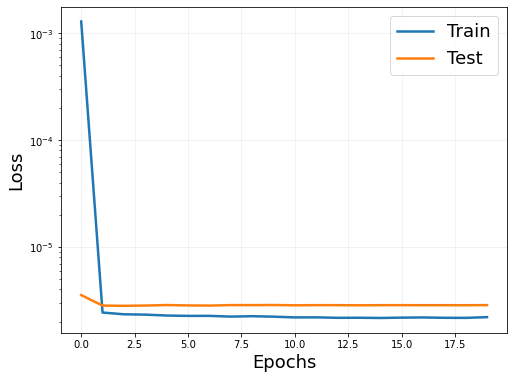

In [22]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [23]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        
        temp_input = x[:,14]
        proj = model(x)
        pred = implicit_diffusion(proj, temp_input)        
        pred = pred.to(dtype=torch.float32)
        
#         print(torch.mean((pred-y)**2))
#         print(y.shape)
        
        y = y * std + mean
        pred = pred * std + mean
        
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_, pred_)
    l2_error_temp = l2_error(y_, pred_)
    return rmse_temp, l2_error_temp

In [24]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 0.009307150131261478
L2 Error  of Temp: 0.0006025864670669463


In [25]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.008142524303035206
L2 Error  of Temp: 0.0005310471749693952


# Saving Model

In [26]:
PATH = f"./saved_models/heat_diffusion_model_time.pth"
torch.save(model.state_dict(), PATH)

In [27]:
output_mean

array([14.30940717])